In [1]:
import numpy as np
import gym
import scipy
import cv2
import matplotlib.pyplot as plt
import skimage.transform as st
from PIL import Image
import seaborn as sns
import matplotlib.animation as animation
from skimage.util import img_as_ubyte

import torch
import torch.nn as nn

sns.set()

In [2]:
def preproc(X):
    r, g, b = X[:,:,0], X[:,:,1], X[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    img_where = np.where((200 > gray) & (gray > 50), 255, 0)
    out = img_as_ubyte(img_where)

    return st.resize(out, (28, 28))

In [3]:
def get_theta(obs):
    '''Transforms coordinate basis from the defaults of the gym pendulum env.'''
    theta = np.arctan2(obs[0], -obs[1])
    theta = theta + np.pi/2
    theta = theta + 2*np.pi if theta < -np.pi else theta
    theta = theta - 2*np.pi if theta > np.pi else theta
    return theta

In [4]:
seed=0
timesteps=100
trials=10
side=28
min_angle=0.
max_angle=np.pi/6, 

gym_settings = locals()

env = gym.make('Pendulum-v0')
env.reset() ; env.seed(seed)

canonical_coords, frames = [], []
for step in range(trials * timesteps):

    if step % timesteps == 0:
        angle_ok = False

        while not angle_ok:
            obs = env.reset()
            theta_init = np.abs(get_theta(obs))
            
            if theta_init > min_angle and theta_init < max_angle:
                angle_ok = True
            
    frames.append(preproc(env.render('rgb_array')))
    obs = env.step([0.])[0]
    theta, dtheta = get_theta(obs), obs[-1]

    # The constant factor of 0.25 comes from saying plotting H = PE + KE*c
    # and choosing c such that total energy is as close to constant as
    # possible. It's not perfect, but the best we can do.
    canonical_coords.append(np.array([theta, 0.25 * dtheta]) )

canonical_coords = np.stack(canonical_coords).reshape(trials*timesteps, -1)
frames = np.array(frames)

env.close()

C:\Users\szcsm\anaconda3\envs\myenv\lib\site-packages\skimage\util\dtype.py:525: UserWarning: Downcasting int32 to uint8 without scaling because max value 255 fits in uint8
  return _convert(image, np.uint8, force_copy)


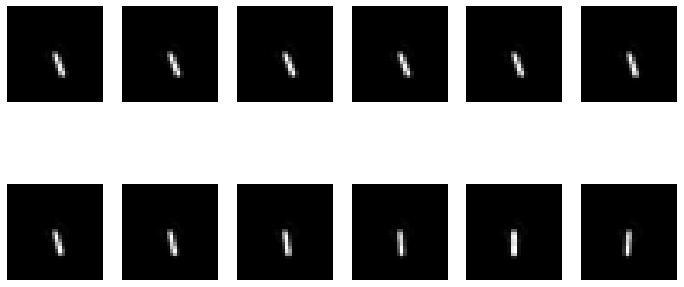

<Figure size 432x288 with 0 Axes>

In [5]:
w=10
h=10
fig=plt.figure(figsize=(12, 6))
columns = 6
rows = 2
for i in range(1, columns*rows +1):
    img = frames[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()
plt.tight_layout()


(500, 56, 28)

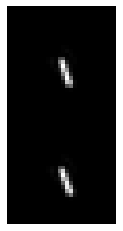

In [6]:
concated = np.concatenate((frames[::2], frames[1::2]), axis=1)
plt.imshow(concated[0], cmap='gray')
plt.axis('off')
concated.shape

In [7]:
concated = torch.Tensor(concated.reshape(int((trials * timesteps) / 2), 56*28))
concated.shape

torch.Size([500, 1568])

In [8]:
train = concated[: int((trials * timesteps) / 4)]
test = concated[int((trials * timesteps) / 4) : ]

In [9]:
print(train.shape, test.shape)

torch.Size([250, 1568]) torch.Size([250, 1568])


In [10]:
train_X, train_y = train[::2], train[1::2]
test_X, test_y = test[::2], test[1::2]

In [11]:
def latent_loss(x, x_next, model):
    # transforming to latent space
    latent = model.encode(x)
    latent_next = model.encode(x_next) #látenst adja vissza a model és azt használni
    # képnél lehet 12-23
    # látens vektorban 12 kép zq_t,p_t,zq_t+1, zp_t+1

    # loss for the autoencoder
    #x_dot = model.decode(latent)
    autoencoder_loss = ((x - x_next)**2).mean(-1)

    # hnn loss
    latent_dot_next = latent + model.model_diff(latent) # ez baseline-nál nem jó
    hnn_loss = ((latent_next - latent_dot_next)**2).mean(-1)

    # special latent space loss
    latent_q, latent_p = latent.split(1,1)
    latent_q_next, Latent_p_next = latent_next.split(1,1)
    latent_loss = ((latent_p - (latent_q - latent_q_next))**2).mean(-1)

    loss = autoencoder_loss + hnn_loss + latent_loss

    return loss.mean()

In [12]:
from models import MLP_autoencoder, PixelHNN


baseline = MLP_autoencoder(dims=56*28)
model = PixelHNN(dims=56*28)

In [13]:
concated[0].shape

torch.Size([1568])

In [14]:
print(train_X.shape, train_y.shape)

torch.Size([125, 1568]) torch.Size([125, 1568])


In [15]:
trainset = torch.utils.data.TensorDataset(train_X, train_y)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=25, shuffle=True, num_workers=2)

In [16]:
import torch.optim as optim

optimizer1 = optim.Adam(baseline.parameters(), lr=1e-3, weight_decay=1e-5)
optimizer2 = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [17]:
'''
%%time
# baseline training
for epoch in range(100):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        outputs = baseline(inputs)
        loss = latent_loss(inputs, outputs, baseline)

        optimizer1.zero_grad()
        loss.backward()
        optimizer1.step()

        # print statistics
        running_loss += loss.item()
        
    if (epoch + 1) % 20 == 0:
        print('Epoch: %d | Loss: %.5f' % (epoch + 1, running_loss))
        running_loss = 0.0
            
print('-----------------------------')
print('Finished Training')
'''

"\n%%time\n# baseline training\nfor epoch in range(100):\n\n    running_loss = 0.0\n    for i, data in enumerate(trainloader, 0):\n        # get the inputs; data is a list of [inputs, labels]\n        inputs, labels = data\n\n        outputs = baseline(inputs)\n        loss = latent_loss(inputs, outputs, baseline)\n\n        optimizer1.zero_grad()\n        loss.backward()\n        optimizer1.step()\n\n        # print statistics\n        running_loss += loss.item()\n        \n    if (epoch + 1) % 20 == 0:\n        print('Epoch: %d | Loss: %.5f' % (epoch + 1, running_loss))\n        running_loss = 0.0\n            \nprint('-----------------------------')\nprint('Finished Training')\n"

In [18]:
%%time
# baseline training
for epoch in range(80):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        outputs = model(inputs)
        loss = latent_loss(inputs, outputs, model)

        optimizer1.zero_grad()
        loss.backward()
        optimizer1.step()

        # print statistics
        running_loss += loss.item()
        
    if (epoch + 1) % 20 == 0:
        print('Epoch: %d | Loss: %.5f' % (epoch + 1, running_loss))
        running_loss = 0.0
            
print('-----------------------------')
print('Finished Training')

Epoch: 20 | Loss: 0.09726
Epoch: 40 | Loss: 0.09726
Epoch: 60 | Loss: 0.09726
Epoch: 80 | Loss: 0.09726
-----------------------------
Finished Training
Wall time: 1min 29s


In [19]:
preds = model(test_X).detach().numpy()

(-0.5, 27.5, 55.5, -0.5)

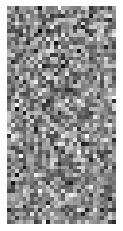

In [20]:
plt.imshow(preds[0].reshape(56, 28), cmap='gray')
plt.axis('off')

In [21]:
latent_space = model.encode(test).detach().numpy() 

Text(0.5, 1.0, 'Latent space')

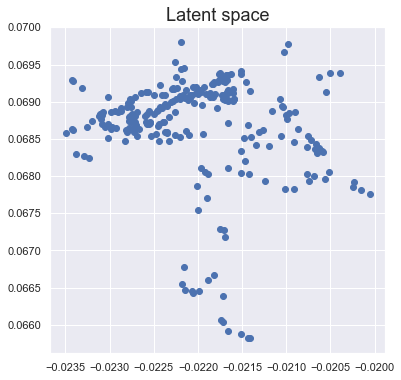

In [22]:
plt.figure(figsize=(6, 6))

plt.plot(latent_space[:,0], latent_space[:,1], 'o')
plt.title('Latent space', size=18)

Text(0.5, 1.0, 'Simulated data')

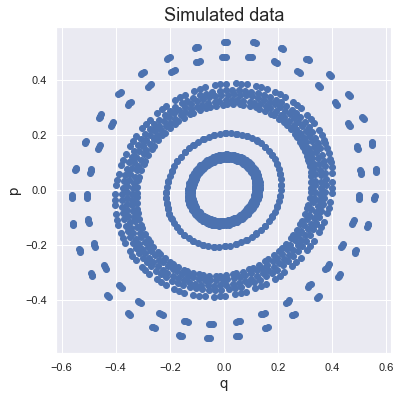

In [23]:
plt.figure(figsize=(6, 6))

plt.plot(canonical_coords[:,0], canonical_coords[:,1], 'o')
plt.xlabel('q', size=15)
plt.ylabel('p', size=15)
plt.title('Simulated data', size=18)